In [66]:
import os
import pandas as pd
import numpy as np
import cv2   
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import urllib.request
from urllib.error import HTTPError

import sys

#if sys.version_info[0] == 3:
#    from urllib.request import urlopen
#else:
    # Not Python 3 - today, it is most likely to be Python 2
    # But note that this might need an update when Python 4
    # might be around one day
#    from urllib import urlopen
from sklearn import metrics
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
from sklearn.utils import shuffle
import math

plt.style.use('ggplot')

%matplotlib inline

import tensorflow as tf
print(tf.__version__)

IMG_WIDTH = 182
IMG_HEIGHT = 268
BATCH_SIZE = 16
NUM_EPOCHS = 15

1.13.1


In [2]:
os.chdir("C:/Users/benja/Desktop/comp562")
print(os.getcwd())
main_folder = 'movie-genre-from-its-poster/'
images_folder = main_folder + 'SampleMoviePosters/SampleMoviePosters/'
images_folder_no_ending = main_folder + 'SampleMoviePosters/SampleMoviePosters'

C:\Users\benja\Desktop\comp562


In [3]:
# import the data set that include the attribute for each picture
#df_attr = pd.read_csv(main_folder + 'MovieGenre.csv')
#df_attr = pd.read_csv('movie-genre-from-its-poster/MovieGenre.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv(main_folder + 'MovieGenre.csv', encoding="ISO-8859-1")
df_attr.set_index(["imdbId"], inplace=True)
df_attr.dropna(inplace=True)

df_attr.drop_duplicates(subset="Poster", keep=False, inplace=True)

df_attr.shape
df_attr.head(n=15)

,Imdb Link,Title,IMDB Score,Genre,Poster
imdbId,,,,,
114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...
113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action|Crime|Drama,https://images-na.ssl-images-amazon.com/images...
114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy|Drama,https://images-na.ssl-images-amazon.com/images...
112302,http://www.imdb.com/title/tt112302,Tom and Huck (1995),5.6,Adventure|Comedy|Drama,https://images-na.ssl-images-amazon.com/images...
114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action|Crime|Thriller,https://images-na.ssl-images-amazon.com/images...


In [9]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5417708323502589583
]


[]

In [10]:
#initial thing to try is classifying action vs non-action movie
#first create a column that is binary data for action or non action where 1 is that it is action
def is_action(r):
    score = r['IMDB Score']
    if score < 5:
        return 0
    elif score >= 5 and score < 8:
        return 1
    elif score >= 8 and score <= 10:
        return 2
df_attr['imdbscore'] = df_attr.apply (lambda row: is_action(row), axis=1)


In [11]:
#we need 3 sets: train, validation, test
#first look at the split of data
print(df_attr[df_attr['imdbscore'] == 1].shape)
print(df_attr[df_attr['imdbscore'] == 0].shape)
#since these sets are uneven, we need to make sure to sample even amounts.
#the split will be 70% train, 15% validation, 15% test


(31692, 6)
(4135, 6)


In [15]:
np.random.seed(23)

def generate_sets(df, columnName):
    df_two = df[df[columnName] == 2]
    df_one = df[df[columnName] == 1]
    df_zero = df[df[columnName] == 0]
    size = df_two.shape[0]

    #make the assumption for now that the set of ones is smaller than the set of zero, we want an approximately equal amount of both
    df_zero = df_zero.sample(n=size)
    df_one = df_one.sample(n=size)
    
    total_df = pd.concat([df_one, df_zero, df_two])
    
    total_df = shuffle(total_df, random_state=1)
    total_rows = total_df.shape[0]
    
    train_end_index = math.floor(total_rows * .7)
    validation_end_index = math.floor(total_rows * .15 + train_end_index)
    test_end_index = math.floor(total_rows * .15 + validation_end_index)
    
    train_set = total_df[0:train_end_index]
    validation_set = total_df[train_end_index+1:validation_end_index]
    test_set = total_df[validation_end_index+1:total_rows]
    
    return (train_set, validation_set, test_set)

train_set, validation_set, test_set = generate_sets(df_attr, 'imdbscore')
TRAINING_SAMPLES = train_set.shape[0]
VALIDATION_SAMPLES = validation_set.shape[0]
TEST_SAMPLES = test_set.shape[0]

In [16]:
download=True
import os
def download_images(df):
    imgFileNames = []
    print(type(df))
    numFailed = 0
    numSucceeded = 0
    for index, row in df.iterrows():
        filePath = str(index)+'.jpg'
       
        exists = os.path.isfile(filePath)
        
        if download and not exists:
            try:
                urllib.request.urlretrieve(row['Poster'], filePath)    
                imgFileNames.append(filePath)
                numSucceeded = numSucceeded + 1
            except Exception as e:
                imgFileNames.append('failed404')
                numFailed = numFailed + 1
                pass
        else:
            try:
                fh = open(filePath, 'r')
                imgFileNames.append(filePath)
                numSucceeded = numSucceeded + 1
                fh.close()
            except FileNotFoundError:
                numFailed = numFailed + 1
                imgFileNames.append('failed404')
    print(str(numFailed) + 'failed')
    print(str(numSucceeded) + 'succeeded')
    imgFileNames = pd.Series(imgFileNames)
    #print(imgFileNames.head(n=7))
    #these few lines are to add filenames to the dataframe and then drop any that gave 404's
    df['filePath'] = imgFileNames.values
    df = df.replace('failed404', np.NaN)
    df = df.dropna() 
    #print(df.head())
    return df
    
                                               

train_set = download_images(train_set)
test_set = download_images(test_set)
validation_set = download_images(validation_set)

<class 'pandas.core.frame.DataFrame'>
150failed
4062succeeded
<class 'pandas.core.frame.DataFrame'>
45failed
858succeeded
<class 'pandas.core.frame.DataFrame'>
41failed
860succeeded


In [17]:
train_set.set_index(["filePath"], inplace=True)
test_set.set_index(["filePath"], inplace=True)
validation_set.set_index(["filePath"], inplace=True)

In [18]:
print(train_set.shape)
print(test_set.shape)
print(validation_set.shape)
train_set.head(n=12)

(4062, 6)
(858, 6)
(860, 6)


,Imdb Link,Title,IMDB Score,Genre,Poster,imdbscore
filePath,,,,,,
1310569.jpg,http://www.imdb.com/title/tt1310569,Before I Self Destruct (2009),4.9,Action|Crime|Drama,https://images-na.ssl-images-amazon.com/images...,0
3124476.jpg,http://www.imdb.com/title/tt3124476,Beethoven's Treasure Tail (2014),4.8,Family,https://images-na.ssl-images-amazon.com/images...,0
2355773.jpg,http://www.imdb.com/title/tt2355773,Paradh (2010),7.2,Drama,https://images-na.ssl-images-amazon.com/images...,1
113199.jpg,http://www.imdb.com/title/tt113199,Gordy (1995),3.9,Comedy|Drama|Family,https://images-na.ssl-images-amazon.com/images...,0
68504.jpg,http://www.imdb.com/title/tt68504,The Mansion of Madness (1973),5.1,Horror,https://images-na.ssl-images-amazon.com/images...,1
57565.jpg,http://www.imdb.com/title/tt57565,High and Low (1963),8.4,Crime|Drama|Mystery,https://images-na.ssl-images-amazon.com/images...,2
36182.jpg,http://www.imdb.com/title/tt36182,My Friend Flicka (1943),6.6,Family|Western,https://images-na.ssl-images-amazon.com/images...,1
2166834.jpg,http://www.imdb.com/title/tt2166834,"Batman: The Dark Knight Returns, Part 2 (2013)",8.4,Animation|Action|Adventure,https://images-na.ssl-images-amazon.com/images...,2
3894312.jpg,http://www.imdb.com/title/tt3894312,The Remains (2016),3.7,Horror|Thriller,https://images-na.ssl-images-amazon.com/images...,0


In [21]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

def setup_images(df_, partition, attr):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(str(fname)) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 268, 182, 3)
        y_ = np_utils.to_categorical(df_[attr],3)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(str(index))
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_


In [22]:
x_train, y_train = setup_images(train_set,0, 'imdbscore')

In [23]:
x_train[1:5]

array([[[[0.5803922 , 0.8       , 0.8509804 ],
         [0.56078434, 0.78039217, 0.83137256],
         [0.5372549 , 0.7607843 , 0.8039216 ],
         ...,
         [0.14117648, 0.56078434, 0.7411765 ],
         [0.13725491, 0.5568628 , 0.7372549 ],
         [0.12156863, 0.5411765 , 0.72156864]],

        [[0.5254902 , 0.78431374, 0.84705883],
         [0.5294118 , 0.7882353 , 0.84313726],
         [0.5294118 , 0.7882353 , 0.8352941 ],
         ...,
         [0.14901961, 0.5647059 , 0.7529412 ],
         [0.14901961, 0.5647059 , 0.7529412 ],
         [0.14509805, 0.56078434, 0.7490196 ]],

        [[0.43137255, 0.7411765 , 0.80784315],
         [0.46666667, 0.7764706 , 0.84313726],
         [0.49019608, 0.8       , 0.85882354],
         ...,
         [0.13725491, 0.5529412 , 0.75686276],
         [0.14117648, 0.5568628 , 0.7607843 ],
         [0.14117648, 0.5568628 , 0.7607843 ]],

        ...,

        [[0.96862745, 0.8745098 , 0.5372549 ],
         [0.84313726, 0.7411765 , 0.44705883]

In [26]:
print(y_train[1:100])

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0.

In [37]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [38]:
x_valid, y_valid = setup_images(validation_set, 1, 'imdbscore')
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)

In [39]:
inc_model = InceptionV3(weights='inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))

number of layers: 311


In [40]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

In [41]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [45]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/15
264/263 [==============================] - 837s 3s/step - loss: 1.1232 - acc: 0.3579 - val_loss: 1.0830 - val_acc: 0.4012

Epoch 00001: val_loss improved from inf to 1.08300, saving model to weights.best.inc.male.hdf5
Epoch 2/15
264/263 [==============================] - 840s 3s/step - loss: 1.1101 - acc: 0.3871 - val_loss: 1.0732 - val_acc: 0.4291

Epoch 00002: val_loss improved from 1.08300 to 1.07317, saving model to weights.best.inc.male.hdf5
Epoch 3/15
264/263 [==============================] - 838s 3s/step - loss: 1.1027 - acc: 0.3845 - val_loss: 1.0609 - val_acc: 0.4326

Epoch 00003: val_loss improved from 1.07317 to 1.06087, saving model to weights.best.inc.male.hdf5
Epoch 4/15
264/263 [==============================] - 840s 3s/step - loss: 1.0892 - acc: 0.4118 - val_loss: 1.0562 - val_acc: 0.4721

Epoch 00004: val_loss improved from 1.06087 to 1.05619, saving model to weights.best.inc.male.hdf5
Epoch 5/15
264/263 [==============================] - 817s 3s/step - los

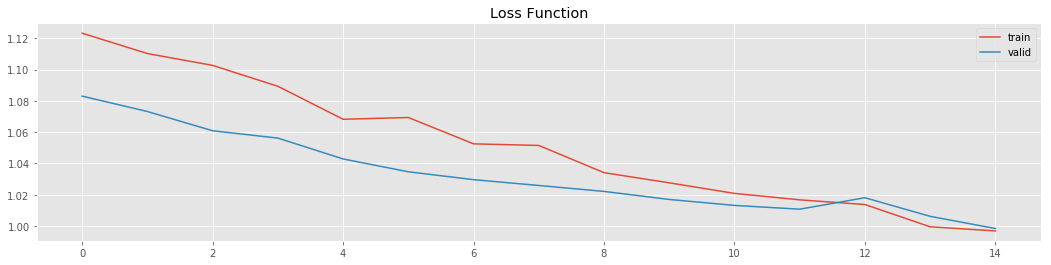

In [50]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

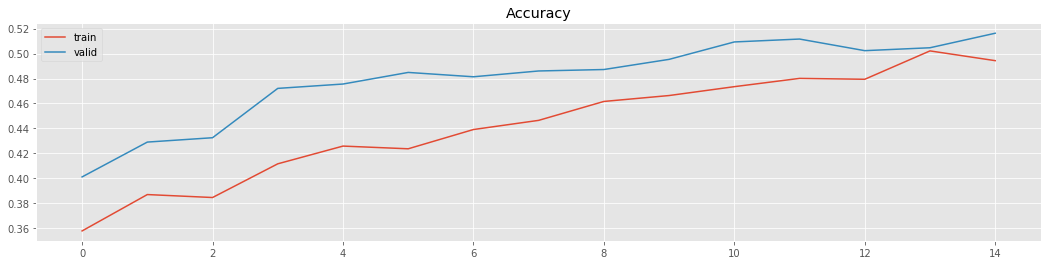

In [51]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [52]:
model_.load_weights('weights.best.inc.male.hdf5')

In [53]:
x_test, y_test =setup_images(test_set, 2, 'imdbscore')

In [64]:

model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions, average='macro'))

Model Evaluation
Test accuracy: 45.8042%
f1_score: 0.44426769845770925


fpr, tpr, thresholds = metrics.roc_curve(y_test, model_predictions)
metrics.auc(fpr, tpr)

ValueError: multiclass format is not supported